<a href="https://colab.research.google.com/github/Deleon57/EDAR-Data/blob/main/XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import datetime as dt
import pandas as pd
from pandas_datareader import data as pdr
from google.colab import files
import yfinance as yf

In [6]:
stocklist = ['GFI', 'FSR']
stocks = [i + '.JO' for i in stocklist]
stocks

['GFI.JO', 'FSR.JO']

In [7]:
start = "2013-03-01"
end = "2024-02-28"


df = yf.download(['GFI.JO', 'FSR.JO'], start=start, end=end)

df.head()

/tmp/ipython-input-2495352864.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(['GFI.JO', 'FSR.JO'], start=start, end=end)
[*********************100%***********************]  2 of 2 completed


Price             Close                      High                       Low  \
Ticker           FSR.JO       GFI.JO       FSR.JO       GFI.JO       FSR.JO   
Date                                                                          
2013-03-01  3121.474365  7431.280273  3132.409467  7503.099358  3062.822458   
2013-03-04  3064.810547  7250.467285  3126.444752  7385.141622  3032.005244   
2013-03-05  3201.001953  7257.449219  3201.001953  7283.386494  3083.698155   
2013-03-06  3107.556885  6928.245117  3220.884295  7299.347663  3105.568685   
2013-03-07  3114.515625  7453.975098  3156.267829  7503.854481  3095.627723   

Price                           Open                 Volume            
Ticker           GFI.JO       FSR.JO       GFI.JO    FSR.JO    GFI.JO  
Date                                                                   
2013-03-01  7338.513956  3084.692661  7465.194841  12379894   5930842  
2013-03-04  7250.467285  3126.444752  7370.177807  14174847   4128626  
2013-03-05  7217.545718  3100.597855  7262.437156  16391688   5666832  
2013-03-06  6928.245117  3202.990494  7258.446576  18189945   6130247  
2013-03-07  7237.498572  3132.409427  7282.390018  18272095  10489933

In [8]:

Close = df['Close']
Close.head()

Ticker,FSR.JO,GFI.JO
Date,,
2013-03-01,3121.474365,7431.280273
2013-03-04,3064.810547,7250.467285
2013-03-05,3201.001953,7257.449219
2013-03-06,3107.556885,6928.245117
2013-03-07,3114.515625,7453.975098


In [9]:
# Select the 'Close' price for 'GFI.JO' as the target variable
target_variable = Close['GFI.JO']

# Use the 'Close' prices of all stocks as features
features = Close

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features, target_variable, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (2237, 2) (2237,)
Testing set shape: (560, 2) (560,)


In [10]:
# Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Display the scaled data
print("Scaled Training Features (first 5 rows):\n", X_train_scaled[:5])
print("\nScaled Testing Features (first 5 rows):\n", X_test_scaled[:5])

Scaled Training Features (first 5 rows):
 [[0.13968606 0.04651525]
 [0.23215955 0.61409809]
 [0.81881765 0.02808133]
 [0.46633275 0.36810555]
 [0.1091016  0.02864782]]

Scaled Testing Features (first 5 rows):
 [[0.46535327 0.35445936]
 [0.49150297 0.08650562]
 [0.38997112 0.01663992]
 [0.68724345 0.9324735 ]
 [0.58266262 0.40764197]]


In [11]:
# Initialize and train the XGBoost Regressor model
xgbr = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, random_state=42)
xgbr.fit(X_train_scaled, y_train)

print("XGBoost model training complete.")

XGBoost model training complete.


In [12]:
# Make predictions on the scaled test data
y_pred = xgbr.predict(X_test_scaled)

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on the test set: {mse}")

Mean Squared Error on the test set: 17742.072621038875


Root Mean Squared Error on the test set: 133.19937169911455
Mean Absolute Error on the test set: 41.473919241768975
R-squared on the test set: 0.999615433363699


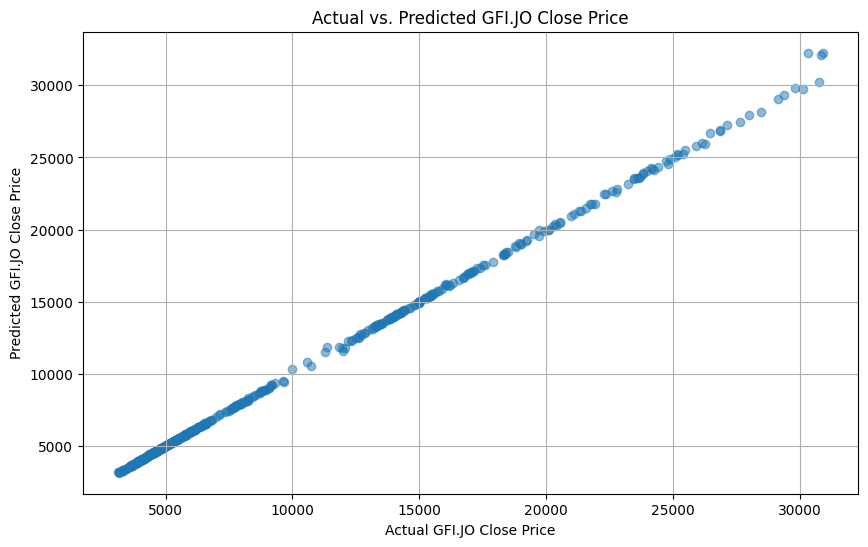

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Calculate RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error on the test set: {rmse}")

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error on the test set: {mae}")

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared on the test set: {r2}")

# Visualize actual vs. predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual GFI.JO Close Price")
plt.ylabel("Predicted GFI.JO Close Price")
plt.title("Actual vs. Predicted GFI.JO Close Price")
plt.grid(True)
plt.show()